# Intro to tensor flow
    - Load MNIST dataset
    - Linear model
    - Convolutional model

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


Tensorflow version:  0.11.0rc2


## Get some data

In [2]:
data_path = '/tmp/'
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(data_path + 'MNIST_data', one_hot=True)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


Train shape:  (55000, 784)
Valid shape:  (5000, 784)
Test  shape:  (10000, 784)


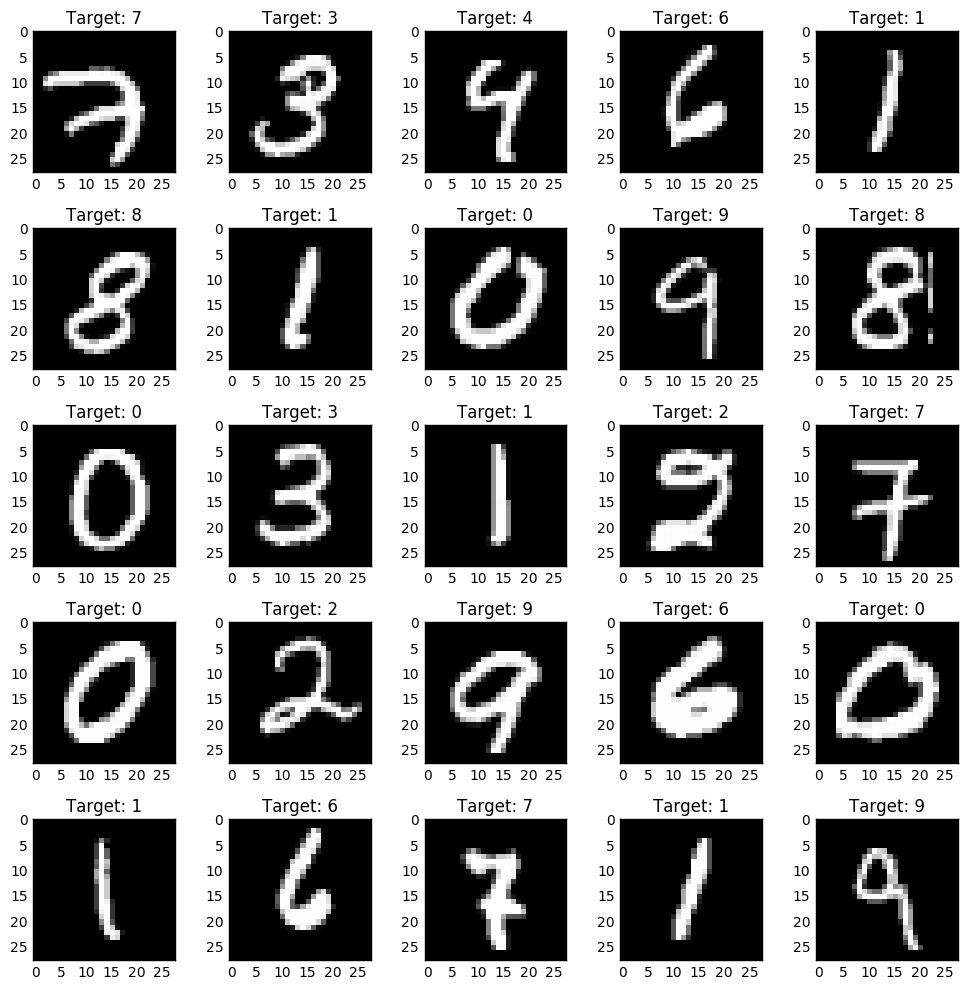

In [3]:
#Examine the data
print('Train shape: ', mnist.train.images.shape)
print('Valid shape: ', mnist.validation.images.shape)
print('Test  shape: ', mnist.test.images.shape)

fig = plt.figure()
for i in xrange(25):
    a = fig.add_subplot(5,5,i+1)
    a.set_title('Target: ' + str(np.argmax(mnist.train.labels[i])))
    fig.tight_layout()
    plt.imshow(np.reshape(mnist.train.images[i],(28,28)))



## Linear model

In [4]:
# Start an interactive session
sess = tf.InteractiveSession()


### Define the graph

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

# Model variables
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# Define the trainer
y_pred = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)


### Train the graph
batch_size = 128
num_epoch = 30

sess.run(tf.initialize_all_variables())

for i in range(num_epoch * 214):  # 214 * 256 aprox 55000 = train size
    batch = mnist.train.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

    
# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    

#When finish, close the interactive session
sess.close()

Test accuracy:  0.9171


## Convolutional model

In [28]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    return conv_out


def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

In [45]:
# Start an interactive session
sess = tf.InteractiveSession()

#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
h_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 1: ', h_pool1)

#Second convolution
h_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv1')
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 2: ', h_pool2)


#First dense layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
print('Dense 1: ', h_fc1)

#Dropout over 
dropout_keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)

#Second dense layer
h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10)
print('Dense 2: ', h_fc2)

#Prediction
y_pred = tf.nn.softmax(h_fc2)

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(h_fc2, y, name='cross_entropy')

#Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#Accuracy
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Conv - pool 1:  Tensor("MaxPool_44:0", shape=(?, 14, 14, 20), dtype=float32)
Conv - pool 2:  Tensor("MaxPool_45:0", shape=(?, 7, 7, 50), dtype=float32)
Dense 1:  Tensor("Relu_78:0", shape=(?, 500), dtype=float32)
Dense 2:  Tensor("Relu_79:0", shape=(?, 10), dtype=float32)


In [46]:
#Inicialization.
sess.run(tf.initialize_all_variables())

# Train proccess
for i in range(2000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1})
        print("step %d, training accuracy %g"%(i, train_accuracy))


step 0, training accuracy 0.140625
step 100, training accuracy 0.21875
step 200, training accuracy 0.734375
step 300, training accuracy 0.9375
step 400, training accuracy 0.898438
step 500, training accuracy 0.90625
step 600, training accuracy 0.929688
step 700, training accuracy 0.945312
step 800, training accuracy 0.953125
step 900, training accuracy 0.9375
step 1000, training accuracy 0.976562
step 1100, training accuracy 0.976562
step 1200, training accuracy 0.960938
step 1300, training accuracy 0.976562
step 1400, training accuracy 0.976562
step 1500, training accuracy 0.984375
step 1600, training accuracy 0.984375
step 1700, training accuracy 0.96875
step 1800, training accuracy 0.984375
step 1900, training accuracy 0.976562


In [49]:
acc_test = 0
for i in range(200):
    batch = mnist.test.next_batch(50)
    acc_test += accuracy.eval(feed_dict = {x:batch[0], y: batch[1], dropout_keep_prob: 1.0})
print("test accuracy: ", acc_test/200.)

test accuracy:  0.97720000118


In [9]:
sess.close()

## Use the val_monitor to show the net
    - The same previous convolutional model with the comand that need tensorboard

Based on https://www.tensorflow.org/versions/r0.7/how_tos/summaries_and_tensorboard/index.html 

In [4]:
import tensorflow as tf

# Start an interactive session
sess = tf.InteractiveSession()


In [5]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    # Add summary ops to collect data
    w_hist = tf.histogram_summary("weights_"+name, W_conv)
    b_hist = tf.histogram_summary("biases_"+name, b_conv)
    return conv_out, w_hist, b_hist


def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

In [6]:

# Start an interactive session
sess = tf.InteractiveSession()

#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
# use a name scope to organize nodes in the graph visualizer
with tf.name_scope("conv1") as scope:
    h_conv1, w_hist_conv1, b_hist_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 1: ', h_pool1)

    # Add summary ops to collect data
    h_pool1_hist = tf.histogram_summary("h_pool1", h_pool1)

#Second convolution
with tf.name_scope("conv2") as scope:
    h_conv2, w_hist_conv2, b_hist_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv2')
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 2: ', h_pool2)
    h_pool2_hist = tf.histogram_summary("h_pool2", h_pool2)


#First dense layer
with tf.name_scope("dense1") as scope:
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
    h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
    print('Dense 1: ', h_fc1)
    dense1_hist = tf.histogram_summary("dense1", h_fc1)

    #Dropout over 
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout')
    h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)

#Second dense layer
with tf.name_scope("dense2") as scope:
    h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10, name='dense2')
    print('Dense 2: ', h_fc2)
    dense2_hist = tf.histogram_summary("dense2", h_fc2)

#Prediction
y_pred = tf.nn.softmax(h_fc2)

# Loss function
with tf.name_scope("xent") as scope:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(h_fc2, y, name='cross_entropy')
    ce_summ = tf.histogram_summary("cross entropy", cross_entropy)


#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#Accuracy
with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


Conv - pool 1:  Tensor("conv1/MaxPool:0", shape=(?, 14, 14, 20), dtype=float32)
Conv - pool 2:  Tensor("conv2/MaxPool:0", shape=(?, 7, 7, 50), dtype=float32)
Dense 1:  Tensor("dense1/Relu:0", shape=(?, 500), dtype=float32)
Dense 2:  Tensor("dense2/Relu:0", shape=(?, 10), dtype=float32)


In [9]:
# Merge all the summaries and write them out to /tmp/mnist_logs
merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("/tmp/tensorboard/mnist_logs", sess.graph)

In [10]:
#Inicialization.
sess.run(tf.initialize_all_variables())

# Train proccess
for i in range(2000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    
    if i % 10 == 0:  # Record summary data, and the accuracy
        train_acc = accuracy.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1.})
        summary_str, test_acc = sess.run([merged, accuracy], 
                                    feed_dict={x: mnist.test.images, y: mnist.test.labels, dropout_keep_prob: 1.})
        writer.add_summary(summary_str, i)
        print("step %d, training accuracy %g, test accuracy %g"%(i, train_acc, test_acc))


step 0, training accuracy 0.109375, test accuracy 0.1149
step 10, training accuracy 0.164062, test accuracy 0.1664
step 20, training accuracy 0.15625, test accuracy 0.1419
step 30, training accuracy 0.265625, test accuracy 0.1985
step 40, training accuracy 0.164062, test accuracy 0.2194
step 50, training accuracy 0.195312, test accuracy 0.2545
step 60, training accuracy 0.335938, test accuracy 0.2859
step 70, training accuracy 0.320312, test accuracy 0.3131
step 80, training accuracy 0.375, test accuracy 0.3656
step 90, training accuracy 0.335938, test accuracy 0.3843
step 100, training accuracy 0.523438, test accuracy 0.4239
step 110, training accuracy 0.375, test accuracy 0.4801
step 120, training accuracy 0.46875, test accuracy 0.551
step 130, training accuracy 0.5, test accuracy 0.5601
step 140, training accuracy 0.617188, test accuracy 0.6145
step 150, training accuracy 0.609375, test accuracy 0.6891
step 160, training accuracy 0.75, test accuracy 0.7433
step 170, training accurac

At the end execute tensorboar with:

cd /tmp

python tensorboard --logdir=./tensorboard

And accest to it in:

localhost:6006


## Save and load models
